# Example parameter inference using synthetic data (in Julia)

##### By James Holehouse: jamesholehouse1@gmail.com

This notebook provides a brief tour of stochastic simulations and parameter inference in stochastic gene expression. It covers usage of a stochastic simulation algorithm (SSA), finite state projection, maximum likelihood parameter inference and Bayesian parameter inference.

The aim of parameter inference is to fit models to data and in the process recover parameters for our models that best explain the data. Parameter inference can also be used in combination with *information criteria* to determine which model is most appropriate for a given set of experimental data. This notebook will not cover information criteria, but they are relativly easy to use. If you want to know more you can email me (I can provide examples) or else speak to Kaan or Ramon (of the [Grima group](https://grimagroup.bio.ed.ac.uk/group-members)).

## Packages

Before running this notebook make sure you install the following packages using the command below (after uncommenting). If you haven't yet installed the latest version of Julia please do so [here](https://julialang.org/downloads/).

In [1]:
# ] add Plots LaTeXStrings Distributions DoubleFloats Plots.PlotMeasures, 
#         Catalyst DiffEqJump FiniteStateProjection OrdinaryDiffEq DifferentialEquations
#             SparseArrays LinearAlgebra Turing BlackBoxOptim, Catalyst

In [2]:
using Plots, LaTeXStrings, Distributions, DoubleFloats, Plots.PlotMeasures, 
        Catalyst, DiffEqJump, FiniteStateProjection, OrdinaryDiffEq, DifferentialEquations, 
            SparseArrays, LinearAlgebra, BlackBoxOptim, Turing
Plots.theme(:dao)

## Creating sythetic data using the SSA 

In this section of the notebook we show how to run the SSA to produce sythetic data. We use a manually coded SSA for clarity that utilises the direct SSA method shown in [Gillespie's review](https://www.annualreviews.org/doi/abs/10.1146/annurev.physchem.58.032806.104637). There do exist packages in Julia that allow one to use the SSA without manually coding it up, and you can explore usage of that with respect to *genetic autoregulation* [here](https://github.com/jamesholehouse/SSAandFSPexample/blob/main/Julia_SSA_FSP_example.ipynb).

The example reaction scheme that we will use in this notebook is the telegraph model of gene expression (for context see introduction to [this paper](https://royalsocietypublishing.org/doi/pdf/10.1098/rsif.2021.0510)). The reaction scheme is explicitly given as,
$$ G\xrightarrow{k_{off}}G^\star, G^\star\xrightarrow{k_{on}}G, G\xrightarrow{k_{m}} G+M, M\xrightarrow{k_{d}}\varnothing.$$
In this notebook we make sure to only use steady state data. This can be taken across a population of cells (e.g., smFISH snapshot data) or in a lineage sense (e.g., mother machine data). Verification that the steady state has been reached in the synthetic data can be seen where the moments (and probability distributions) do not change in time.

Let's create some population snapshot and lineage data. We assume that we have access to the mRNA number, but not the gene state since this is difficult to measure in real experiments. First we need to import the SSA package.

In [3]:
path_to_folder = pwd(); file_path = join([path_to_folder,"/SSA-TM.jl"]);
include(file_path);
using .SSATM

And now choose a parameter set corresponding to the sythetic data set.

In [4]:
pars = [2.0,1.0,10.0,0.5]; # in order kon, koff, km, kd

At steady state we have indistinguishability in one of the parameters (i.e., increasing all rate parameters by some scale factor $c$ gives the same probability distribution). Therefore we define a rescaled parameter set too (rescaled by $k_d$).

In [34]:
rs_pars = pars./pars[4]

4-element Vector{Float64}:
  4.0
  2.0
 20.0
  1.0

First, let's produce some population data over 100 cells (make sure to check that steady state has been reached). The arguments of the SSA function correspond to: (1) the number of independent SSA runs (the number of cells), (2) the parameters for the simulation, (3) the total simulation time, and (4) the storage period. We take our population snapshot at the final timepoint for $M$ data across all the cells.

In [6]:
pop_data = SSA(100, pars, 1000, 1.0)[2,:,end]
print(transpose(pop_data)) # print the mRNA numbers

[25.0 20.0 12.0 16.0 18.0 19.0 13.0 22.0 6.0 13.0 24.0 16.0 12.0 19.0 9.0 20.0 10.0 11.0 19.0 15.0 10.0 12.0 8.0 9.0 8.0 14.0 7.0 11.0 12.0 24.0 4.0 13.0 9.0 17.0 14.0 9.0 16.0 18.0 11.0 7.0 11.0 15.0 19.0 11.0 7.0 7.0 10.0 11.0 15.0 9.0 20.0 21.0 12.0 20.0 14.0 14.0 17.0 12.0 18.0 16.0 14.0 16.0 19.0 6.0 18.0 12.0 15.0 10.0 25.0 17.0 22.0 25.0 13.0 17.0 15.0 11.0 14.0 10.0 11.0 11.0 12.0 4.0 22.0 7.0 8.0 14.0 16.0 12.0 10.0 11.0 20.0 16.0 9.0 15.0 17.0 16.0 18.0 5.0 18.0 8.0]

Second, let's produce some lineage data. Now our data will consist of a single SSA run, but we follow a steady state trajectory over many timepoints. Let's say we have access to 100 individual readings in time.

In [7]:
all_lin_data = SSA(1, pars, 1000, 1.0)
# take 100 timepts of this lineage data.
lin_data = all_lin_data[2,:,end-99:end]
# convert data to a Vector
l_data = vcat(lin_data...);

For clarity, we can plot the lineage data and see how it fluctuates. Before this though make a color blind color scheme.

In [8]:
pal = cgrad(:tol_muted);
chosen_pal = [pal[i] for i in 0.1:0.1:0.7]

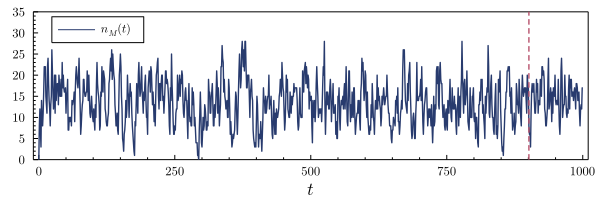

In [9]:
time_pts = collect(0:1.0:1000.0)
plot(time_pts,vcat(all_lin_data[2,:,:]...), label = L"$n_M(t)$", legend = :topleft, 
    bottom_margin = 3PlotMeasures.mm, lc = chosen_pal[3], xlim = (-10,1010), ylim = (0,35))
plot!(grid = false, minorgrid = false, size = (600,200))
plot!([901,901],[0,40], style = :dash, label = :none, lc = chosen_pal[7])
xlabel!(L"t")

The data to the right of the dotted red line above is the lineage data we use in this tutorial. For the rest of this tutorial we will explicitly do inference with the lineage data (although very easily one could use the population data). 

## Numerical analytics using the FSP for fast evaluation 

When using Julia it can be quite tricky to use exact solutions for probability distributions that have a complicated functional form. For example, the solution to the telegraph model comes in the form of a hypergeometric function (see SI protocol of [this](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.0040309#s5)). It can thus be easier to utilise compuational methods to solve a truncated state space version of our system. One can then either refer to the orignal FSP papers [here](https://aip.scitation.org/doi/full/10.1063/1.2145882) and [here](https://aip.scitation.org/doi/full/10.1063/1.5006484) or else look at the associated section in the following [PhD thesis](https://github.com/jamesholehouse/jamesholehouse.github.io/blob/gh-pages/assets/papers/PhD_Thesis-2.pdf). In this notebook we utilise the steady state FSP as shown in the PhD thesis.

In short, the FSP provides a way to evaluate the chemical master equation under a finite state approximation of an infinite state space problem. In our system, $M$ is an unbounded species, meaning that there is a finite probability $P(n_M)$ of having any value of $n_M\in [0,1,2,\dots,\infty)$. For our example above, we use a state space truncation of $N=100$, since $P(N)$ is then a very small probability for the parameters in `pars`.

In this tutorial we have manually coded up an FSP for clarity, however, one can easily do this for any reaction scheme using methods from [`FiniteStateProjection.jl`](https://github.com/kaandocal/FiniteStateProjection.jl) (see [here](https://github.com/jamesholehouse/SSAandFSPexample/blob/main/Julia_SSA_FSP_example.ipynb) for an example applied to genetic autoregulation).

First, let's import the FSP package from our filepath.

In [16]:
file_path2 = join([path_to_folder,"/FSP-TM.jl"]);
include(file_path2);
using .FSPTM

One can then use the FSP to output a probability distribution of interest.

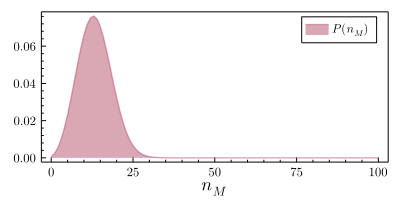

In [28]:
# set state space truncation.
N = 100;
Pn_true = FSP(pars, N);
plot(0:N,Pn_true, label = L"P(n_M)", legend = :topright, lc = chosen_pal[7], 
    fill = true, c = chosen_pal[7], alpha=0.5)
plot!(grid = false, minorgrid = false, size = (400,200))
xlabel!(L"n_M")

We can also make a quick sanity check that the probability sums to 1.

In [29]:
sum(Pn_true)

1.0

Which it does! Finally, given some lineage data one can calculate the log-likelhood of observing a given steady state trajectory given the underlying probability distribution. Using the lineage data above and our FSP this gives...

In [31]:
true_min_llh = -sum([log10(Pn_true[floor(Int,x)]) for x in l_data])

124.9627498804219540613384784071370035985560371542845349855449925241264948048252

We will comment on why we do this below, just keep this number in mind.

## Maximum likelihood estimation (using BlackBoxOptim.jl)

### What is maximum likelihood estimation (MLE)?

Maximum likehood estimation is the process of identifying a set of parameters in a model that maximises the likelihood of the observed data. For our example, for each observation in `l_data` we can calculate the likelihood as the product of the probabilities of each observation, i.e., $\mathcal{L} = \prod_{i\in l_{\mathrm{data}}} P(i)$ (events assumed independent therefore the probability of seeing all events together is simply the product). Say we don't know the optimal parameters $\theta_{\mathrm{max}} = (k_{on},k_{off},k_m,k_d)$, but that for any set $\theta$ we can calucate $P(n_M|\theta)$. The likelihood of observing the data for some parameter set $\theta$ is then $\mathcal{L}(\theta) = \prod_{i\in l_{\mathrm{data}}} P(i|\theta)$. By maximising this likelihood one can then determine the parameters of the model that best describe the data.

In practise $\mathcal{L}(\theta)$ is very small, therefore it is more computationally viable to minimise the negative logarithm of $\mathcal{L}(\theta)$.

### Specifying a cost function

We now need a function that will calculate the negative logarithm of the likelihood of the data given a set of parameters. Note that the optimisation itself will be done in log-space, hence the `log10`'s and `10 .^`'s below.

Note that due to the indistinguishability at steady state, we will set $k_d=1$ and infer the other three remaining parameters. One can then compare the results of the inference to `rs_pars`.

In [44]:
# θ is a three-element vector
function negllh(θ)
    # kd fixed at 1
    FSPprob = FSP(vcat(10 .^θ, 1.0), N)
    return -sum([log10(FSPprob[floor(Int,x)]) for x in l_data])
end

negllh (generic function with 1 method)

As a test let's use some random parameter set.

In [43]:
negllh(log10.([0.001,2.0,4.0]))

920.9735476355219685381562172044228862830393694440592454078604563492149510469001

As expected this gives a much larger NLL than the true parameters.

### Optimising the cost function

We can now use optimisation algorithms to provide a *point estimate* of the set of parameters that best describe the data. There are two possible options here: local optimisation and global optimisation. Local optimisation, although not guaranteed to find a global minimum in a "finite" time, will generally find a very good local minimum in a short amount of time. On the other hand, global optimisation is guaranteed to find the global minimum in a "finite" time, but this can take a very long time and often it takes a great deal of time to find a minmum as good as local optimisation. In this notebook we will show how to use both and compare the results!

Starting with the local optimisation, we use the package `Optim.jl` and specifically the Nelder-Mead algorithm.

In [35]:
using Optim

The choice of starting point is very important in local optimisation. Start in at the wrong point in parameter space and a bad local optima may be chosen. With no information start with something uniform, say $\theta$

In [ ]:
nmopt = optimize(cost_fn_llh, log10_inf_pars[i])

## Bayesian inference (using Turing.jl)